In [6]:
## CLEANING AND DATA PROCESSING

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import warnings
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import f1_score
warnings.filterwarnings("ignore")
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
import numpy as np
import ast
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import LabelEncoder

In [2]:
# plogs = pd.read_csv('plogs.csv')
# pdets = pd.read_csv('pdets.csv')
#
# print("---- plogs.csv ----")
# print(plogs.shape)
# print(plogs.head())
# print(plogs.nunique())
# print(plogs.isnull().sum())
#
# print("\n---- pdets.csv ----")
# print(pdets.shape)
# print(pdets.head())
# print(pdets.nunique())
# print(pdets.isnull().sum())
#
# print("\nNumerical Description (plogs)")
# print(plogs.describe())
#
# print("\nNumerical Description (pdets)")
# print(pdets.describe())
#
# categorical_plogs = plogs.select_dtypes(include=['object', 'category']).columns
# print("\nCategorical Description (plogs)")
# print(plogs[categorical_plogs].describe())
#
# categorical_pdets = pdets.select_dtypes(include=['object', 'category']).columns
# print("\nCategorical Description (pdets)")
# print(pdets[categorical_pdets].describe())
#
# IMP_PLOGS_FIELDS = ['problem_id', 'student_id', 'assignment_id', 'problem_completed', 'correct']
# IMP_PDETS_FIELDS = ['problem_id', 'problem_type', 'content_source', 'skills']
#
# print("\n-- plogs important field value counts --")
# for col in IMP_PLOGS_FIELDS:
#     print(f"Value counts for {col}:")
#     print(plogs[col].value_counts(dropna=False).head(10))  # top 10
#
# print("\n-- pdets important field value counts --")
# for col in IMP_PDETS_FIELDS:
#     print(f"Value counts for {col}:")
#     print(pdets[col].value_counts(dropna=False).head(10))  # top 10
#
# merged = pd.merge(
#     plogs,
#     pdets,
#     how='left',
#     on='problem_id'
# )
# print("\nMerged shape:", merged.shape)
# print(merged.head())
#
# missing_metadata_count = merged['content_source'].isnull().sum()
# print(f"Logs with no matching problem metadata: {missing_metadata_count}")
#
# merged.to_csv('plogs_with_metadata.csv', index=False)
# print("Saved merged file as plogs_with_metadata.csv")

In [3]:
# merged = pd.read_csv('plogs_with_metadata.csv')
# df = merged.copy()
#
# df = df.dropna(subset=['skills', 'correct'])
#
# def safe_parse(x):
#     try: return ast.literal_eval(x) if isinstance(x,str) else []
#     except: return []
# df['skills_list'] = df['skills'].map(safe_parse)
# df = df.explode('skills_list').rename(columns={'skills_list':'skill'})
# df = df.dropna(subset=['skill'])
#
# df['correct'] = df['correct'].map({True: 1, False: 0})
#
# df['time_on_task'] = df['time_on_task'].fillna(df['time_on_task'].median())
# df['time_on_task'] = np.clip(df['time_on_task'], 1, 1200)
#
# df['fraction_of_hints_used'] = df['fraction_of_hints_used'].fillna(0.0)
#
# def to_binary(col):
#     return col.map({True:1, False:0, 'True':1, 'False':0}).fillna(0)
#
# df['answer_before_tutoring'] = to_binary(df['answer_before_tutoring'])
# df['answer_given'] = to_binary(df['answer_given'])
# df['problem_completed'] = to_binary(df['problem_completed'])
#
# for col in ['problem_type', 'content_source', 'tutoring_types']:
#     df[col] = df[col].fillna('Unknown')
#     df[col] = df[col].astype('category')
#
# df['mean_correct'] = df['mean_correct'].fillna(df['mean_correct'].mean())
# df['mean_time_on_task'] = df['mean_time_on_task'].fillna(df['mean_time_on_task'].mean())
# df['student_answer_count'] = df['student_answer_count'].fillna(0).astype(int)
#
# print("Rows after cleaning:", len(df))
# df.info()
# df.to_csv('plogs_with_metadata_cleaned.csv', index=False)

In [4]:
# for col in ['student_id', 'problem_id', 'skill', 'problem_type', 'content_source', 'tutoring_types']:
#     print(f"{col}: {df[col].nunique()} unique values")

In [5]:
## MODELING and FEATURE ENGINEERING (CLUSTERING AND CLASSIFICATION: RANDOM FOREST)

Starting script...
Reading CSV...
Raw df shape: (7106683, 20)
Applied safe_literal_eval for columns ['skills', 'tutoring_types', 'content_source']
Added 'main_skill' and label encoded as 'main_skill_enc'.
Non-null main_skill count: 7106683/7106683
agg shape (after groupby): (874525, 9)


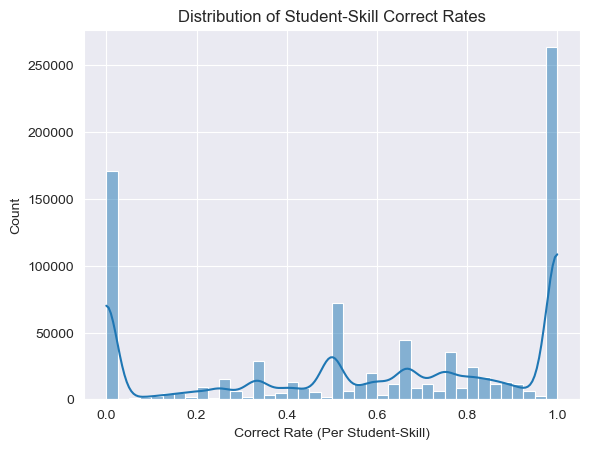

33rd percentile: 0.500 | 66th percentile: 0.870
Running KMeans clustering (k=3)...
KMeans cluster centers: [np.float64(0.0802982282724487), np.float64(0.5878767917537284), np.float64(0.9607151651350343)]
KMeans cluster label distribution:
cluster
1    358175
2    267409
0    248941
Name: count, dtype: int64
Cluster 0 center: 0.080
Cluster 1 center: 0.588
Cluster 2 center: 0.961


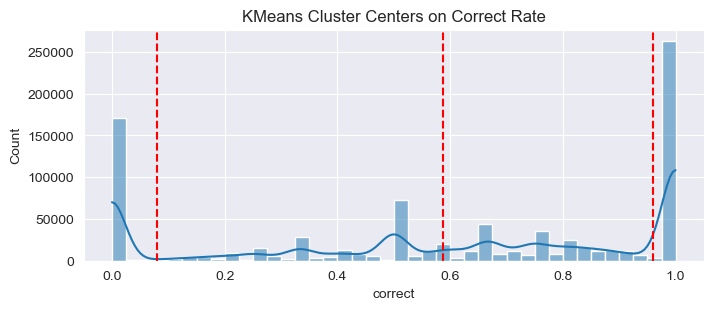


Quantile-based skill level counts:
skill_level_quantiles
0    356557
2    297193
1    220775
Name: count, dtype: int64

KMeans skill level counts:
skill_level_kmeans
1    358175
2    267409
0    248941
Name: count, dtype: int64

Sample of agg dataframe after labeling:
         correct skill_level_quantiles  skill_level_kmeans
563098  0.500000                     0                   2
448703  0.900000                     2                   1
221671  0.666667                     1                   2
749800  1.000000                     2                   1
10808   0.574468                     1                   2

Script finished.


In [6]:
print("Starting script...")

print("Reading CSV...")
df = pd.read_csv('plogs_with_metadata_cleaned.csv')
print(f"Raw df shape: {df.shape}")

def safe_literal_eval(val):
    if isinstance(val, list): return val
    if isinstance(val, str):
        val = val.strip()
        if (val.startswith('[') and val.endswith(']')) or (val.startswith('{') and val.endswith('}')):
            try: return ast.literal_eval(val)
            except Exception: return [val]
        return [val]
    return [val]

for col in ['skills', 'tutoring_types', 'content_source']:
    df[col] = df[col].apply(safe_literal_eval)
print(f"Applied safe_literal_eval for columns ['skills', 'tutoring_types', 'content_source']")

df['main_skill'] = df['skills'].apply(lambda x: x[0] if isinstance(x, list) and len(x) else None)
labeler = LabelEncoder()
df['main_skill_enc'] = labeler.fit_transform(df['main_skill'].astype(str))
print("Added 'main_skill' and label encoded as 'main_skill_enc'.")
print(f"Non-null main_skill count: {df['main_skill'].notnull().sum()}/{len(df)}")

agg = df.groupby(['student_id', 'main_skill']).agg({
    'correct': 'mean',
    'attempt_count': 'mean',
    'fraction_of_hints_used': 'mean',
    'time_on_task': 'mean',
    'problem_completed': 'mean',
    'student_answer_count': 'mean'
}).reset_index()
agg['main_skill_enc'] = labeler.transform(agg['main_skill'].astype(str))
print(f"agg shape (after groupby): {agg.shape}")

sns.histplot(agg['correct'], bins=40, kde=True)
plt.xlabel('Correct Rate (Per Student-Skill)')
plt.ylabel('Count')
plt.title('Distribution of Student-Skill Correct Rates')
plt.show()

q1, q2 = np.percentile(agg['correct'], [33, 66])
print(f'33rd percentile: {q1:.3f} | 66th percentile: {q2:.3f}')

print("Running KMeans clustering (k=3)...")
kmeans = KMeans(n_clusters=3, random_state=0)
agg['cluster'] = kmeans.fit_predict(agg[['correct']])
centers = sorted(kmeans.cluster_centers_.flatten())
print(f"KMeans cluster centers: {centers}")

print("KMeans cluster label distribution:")
print(agg['cluster'].value_counts())
for i, center in enumerate(centers):
    print(f"Cluster {i} center: {center:.3f}")

plt.figure(figsize=(8,3))
sns.histplot(agg['correct'], bins=40, kde=True)
for c in centers:
    plt.axvline(c, color='r', linestyle='--')
plt.title('KMeans Cluster Centers on Correct Rate')
plt.show()

agg['skill_level_quantiles'] = pd.cut(agg['correct'], bins=[0., q1, q2, 1.], labels=[0,1,2], include_lowest=True)
agg['skill_level_kmeans'] = agg['cluster']

print("\nQuantile-based skill level counts:")
print(agg['skill_level_quantiles'].value_counts())
print("\nKMeans skill level counts:")
print(agg['skill_level_kmeans'].value_counts())

print("\nSample of agg dataframe after labeling:")
print(agg[['correct', 'skill_level_quantiles', 'skill_level_kmeans']].sample(5))

print("\nScript finished.")


In [7]:
## LABELLING FOR CLASSFICATION

In [8]:
# --- Quantile(Percentile) based labeling ---
agg_quantile = agg.copy()
q1, q2 = np.percentile(agg_quantile['correct'], [33, 66])
agg_quantile['skill_level_quantile'] = pd.cut(
    agg_quantile['correct'],
    bins=[0., q1, q2, 1.],
    labels=['weak', 'average', 'strong'],
    include_lowest=True
)

print("Quantile thresholds (tertiles):")
print(f"  33rd percentile: {q1:.3f}, 66th percentile: {q2:.3f}")
print("Class sizes (quantile):")
print(agg_quantile['skill_level_quantile'].value_counts())

# --- Mastery-based labeling (threshold, e.g. 0.8 for strong) ---
agg_mastery = agg.copy()
mastery_threshold = 0.8
bins = [0., 0.5, mastery_threshold, 1.]
labels = ['weak', 'average', 'strong']
agg_mastery['skill_level_mastery'] = pd.cut(
    agg_mastery['correct'], bins=bins, labels=labels, include_lowest=True
)
print("\nMastery threshold for 'strong':", mastery_threshold)
print("Class sizes (mastery):")
print(agg_mastery['skill_level_mastery'].value_counts())

Quantile thresholds (tertiles):
  33rd percentile: 0.500, 66th percentile: 0.870
Class sizes (quantile):
skill_level_quantile
weak       356557
strong     297193
average    220775
Name: count, dtype: int64

Mastery threshold for 'strong': 0.8
Class sizes (mastery):
skill_level_mastery
weak       356557
strong     332518
average    185450
Name: count, dtype: int64



Feature correlation (Quantile-based):


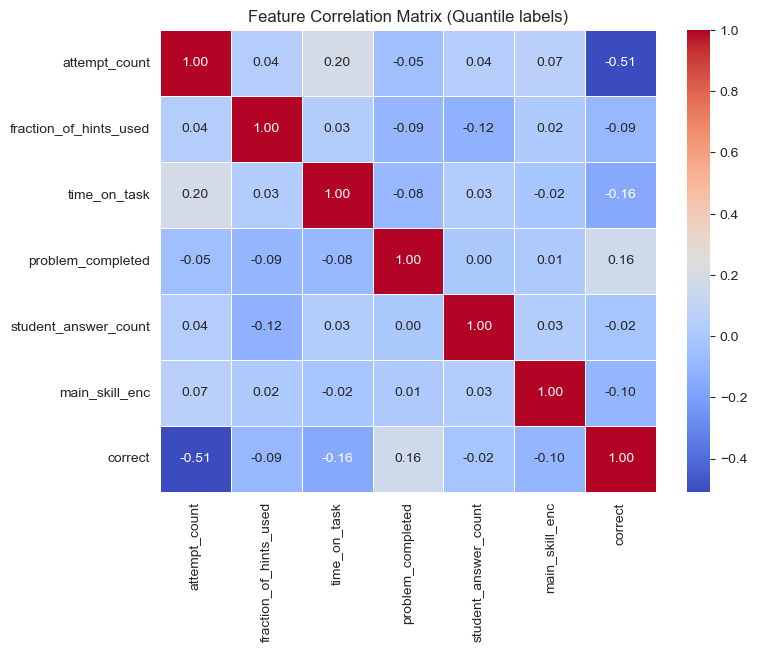


Feature correlation (Mastery-based):


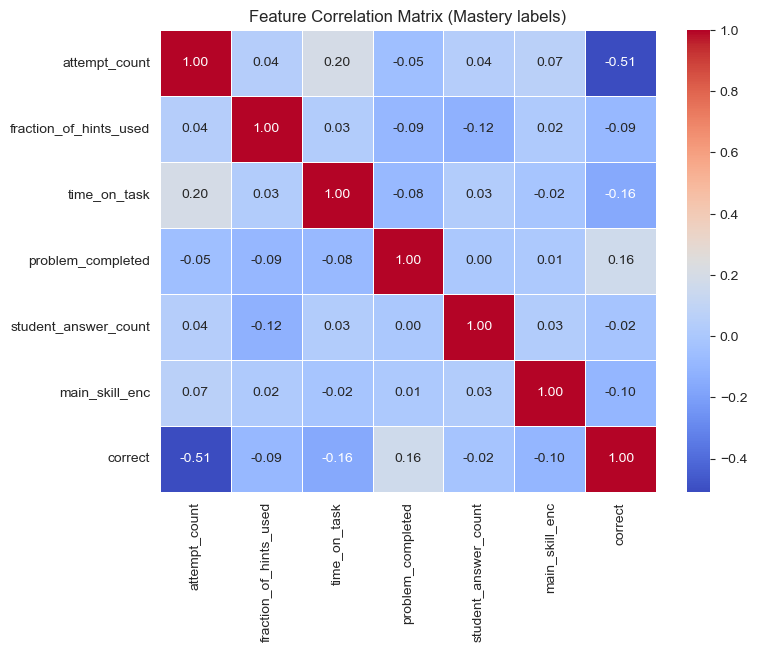

In [9]:
# For quantile approach
features = [
    'attempt_count', 'fraction_of_hints_used', 'time_on_task',
    'problem_completed', 'student_answer_count', 'main_skill_enc'
]
print("\nFeature correlation (Quantile-based):")
corr = agg_quantile[features + ['correct']].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title("Feature Correlation Matrix (Quantile labels)")
plt.show()

# For mastery approach
print("\nFeature correlation (Mastery-based):")
corr = agg_mastery[features + ['correct']].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title("Feature Correlation Matrix (Mastery labels)")
plt.show()

In [10]:
# MODEL

In [11]:
RANDOM_STATE = 42


def train_rf_and_report(data, label_col, label_name):
    d2 = data.dropna(subset=[label_col]).copy()
    X = d2[features]
    y = d2[label_col]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

    clf = RandomForestClassifier(max_depth=8, n_estimators=80, random_state=RANDOM_STATE)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    print(f"\n=== {label_name} LABELS ===")
    print(f"Train set size: {len(X_train)}, Test set size: {len(X_test)}")
    print(pd.Series(y_test).value_counts())
    print(classification_report(y_test, y_pred, digits=3))

# --- Quantile-based modeling ---
train_rf_and_report(agg_quantile, 'skill_level_quantile', 'Quantile-based (tertile)')

# --- Mastery-based modeling ---
train_rf_and_report(agg_mastery, 'skill_level_mastery', 'Mastery threshold-based')


=== Quantile-based (tertile) LABELS ===
Train set size: 699620, Test set size: 174905
skill_level_quantile
weak       71311
strong     59439
average    44155
Name: count, dtype: int64
              precision    recall  f1-score   support

     average      0.801     0.640     0.712     44155
      strong      0.855     0.967     0.908     59439
        weak      0.810     0.822     0.816     71311

    accuracy                          0.826    174905
   macro avg      0.822     0.810     0.812    174905
weighted avg      0.823     0.826     0.821    174905


=== Mastery threshold-based LABELS ===
Train set size: 699620, Test set size: 174905
skill_level_mastery
weak       71311
strong     66504
average    37090
Name: count, dtype: int64
              precision    recall  f1-score   support

     average      0.716     0.568     0.633     37090
      strong      0.856     0.937     0.895     66504
        weak      0.807     0.822     0.814     71311

    accuracy                     

In [12]:
## LEARNING CURVE


Learning curve: Quantile


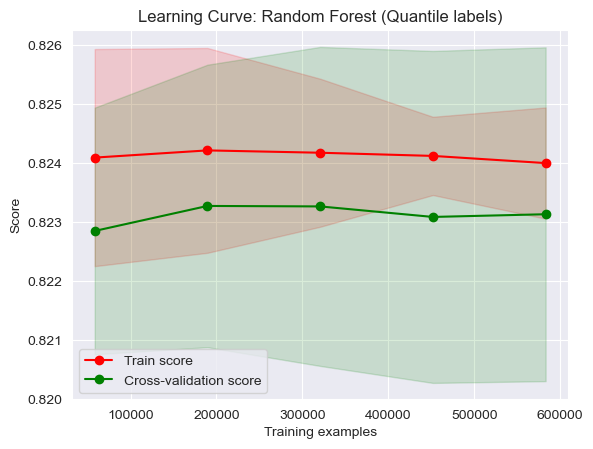


Learning curve: Mastery


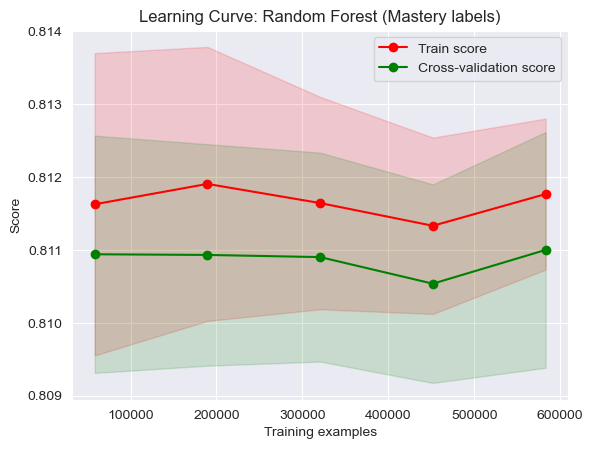

In [13]:
def plot_learning_curve(estimator, X, y, title):
    train_sizes, train_scores, val_scores = learning_curve(
        estimator, X, y, cv=3, train_sizes=np.linspace(0.1, 1.0, 5), scoring='accuracy', n_jobs=-1, shuffle=True, random_state=RANDOM_STATE)

    train_mean, train_std = train_scores.mean(axis=1), train_scores.std(axis=1)
    val_mean, val_std = val_scores.mean(axis=1), val_scores.std(axis=1)

    plt.figure()
    plt.plot(train_sizes, train_mean, 'o-', label='Train score', color='red')
    plt.plot(train_sizes, val_mean, 'o-', label='Cross-validation score', color='green')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.15, color='red')
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.15, color='green')
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.title(title)
    plt.show()

# For Quantile model
print("\nLearning curve: Quantile")
d2 = agg_quantile.dropna(subset=['skill_level_quantile'])
X = d2[features]
y = d2['skill_level_quantile']
rf = RandomForestClassifier(max_depth=8, n_estimators=80, random_state=RANDOM_STATE)
plot_learning_curve(rf, X, y, "Learning Curve: Random Forest (Quantile labels)")

# For Mastery model
print("\nLearning curve: Mastery")
d2 = agg_mastery.dropna(subset=['skill_level_mastery'])
X = d2[features]
y = d2['skill_level_mastery']
rf = RandomForestClassifier(max_depth=8, n_estimators=80, random_state=RANDOM_STATE)
plot_learning_curve(rf, X, y, "Learning Curve: Random Forest (Mastery labels)")

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, learning_curve

def train_and_report(data, label_col, label_name, estimator, features, random_state=42):
    d2 = data.dropna(subset=[label_col]).copy()
    X = d2[features]
    y = d2[label_col]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=random_state, stratify=y)

    estimator.fit(X_train, y_train)
    y_pred = estimator.predict(X_test)

    print(f"\n=== {label_name} LABELS ===")
    print(f"Train set size: {len(X_train)}, Test set size: {len(X_test)}")
    print(pd.Series(y_test).value_counts())
    print(classification_report(y_test, y_pred, digits=3))


RANDOM_STATE = 42

models = [
    ("Logistic Regression", LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)),
    ("K-Nearest Neighbors", KNeighborsClassifier(n_neighbors=7)),
    ("Gradient Boosting", GradientBoostingClassifier(n_estimators=80, max_depth=5, random_state=RANDOM_STATE)),
    ("AdaBoost", AdaBoostClassifier(n_estimators=80, random_state=RANDOM_STATE)),
    ("Gaussian Naive Bayes", GaussianNB()),
    # ("Support Vector Machine", SVC(kernel='rbf', probability=True, random_state=RANDOM_STATE)),
]

# For Quantile-based model
for name, model in models:
    print(f"\n{name}")
    train_and_report(agg_quantile, 'skill_level_quantile', f"Quantile-based ({name})", model, features)

# For Mastery-based model
for name, model in models:
    print(f"\n{name}")
    train_and_report(agg_mastery, 'skill_level_mastery', f"Mastery threshold-based ({name})", model, features)



Logistic Regression

=== Quantile-based (Logistic Regression) LABELS ===
Train set size: 699620, Test set size: 174905
skill_level_quantile
weak       71311
strong     59439
average    44155
Name: count, dtype: int64
              precision    recall  f1-score   support

     average      0.773     0.548     0.642     44155
      strong      0.842     0.969     0.901     59439
        weak      0.771     0.812     0.791     71311

    accuracy                          0.799    174905
   macro avg      0.795     0.777     0.778    174905
weighted avg      0.796     0.799     0.791    174905


K-Nearest Neighbors

=== Quantile-based (K-Nearest Neighbors) LABELS ===
Train set size: 699620, Test set size: 174905
skill_level_quantile
weak       71311
strong     59439
average    44155
Name: count, dtype: int64
              precision    recall  f1-score   support

     average      0.442     0.486     0.463     44155
      strong      0.572     0.564     0.568     59439
        weak      0.


=== PLOTTING LEARNING CURVES: Quantile labels ===

Learning curve: Logistic Regression


/Users/anehra/anaconda3/envs/latest/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/anehra/anaconda3/envs/latest/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

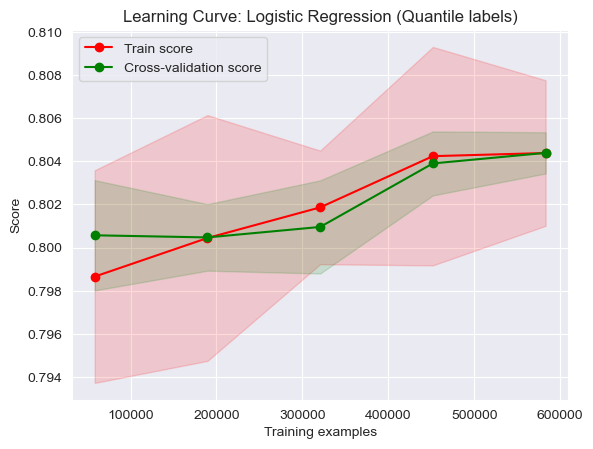


Learning curve: K-Nearest Neighbors


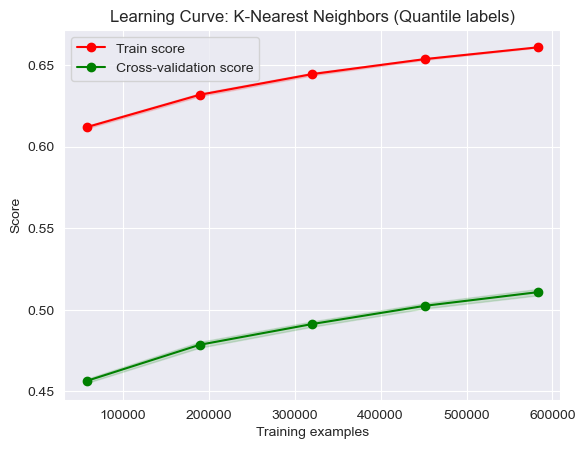


Learning curve: Gradient Boosting


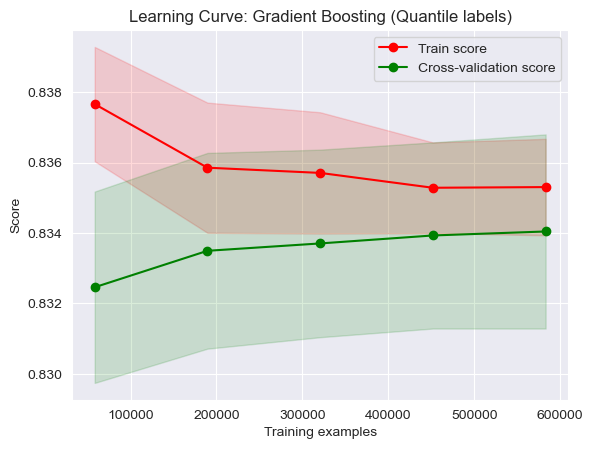


Learning curve: AdaBoost


/Users/anehra/anaconda3/envs/latest/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/anehra/anaconda3/envs/latest/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/anehra/anaconda3/envs/latest/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/anehra/anaconda3/envs/latest/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed i

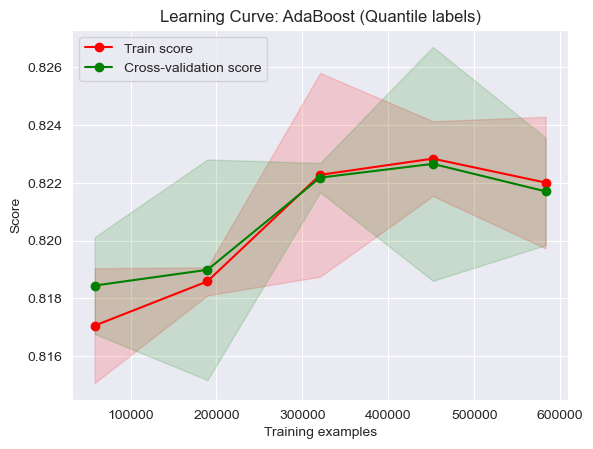


Learning curve: Gaussian Naive Bayes


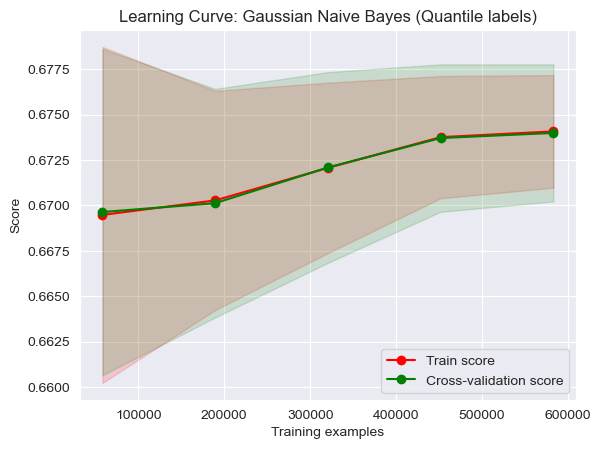


=== PLOTTING LEARNING CURVES: Mastery labels ===

Learning curve: Logistic Regression


/Users/anehra/anaconda3/envs/latest/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/anehra/anaconda3/envs/latest/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

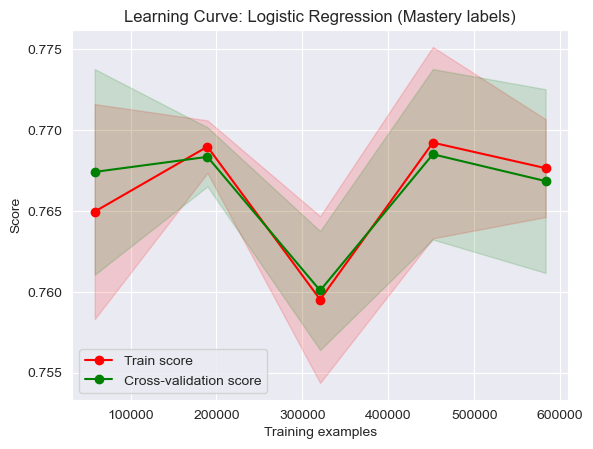


Learning curve: K-Nearest Neighbors


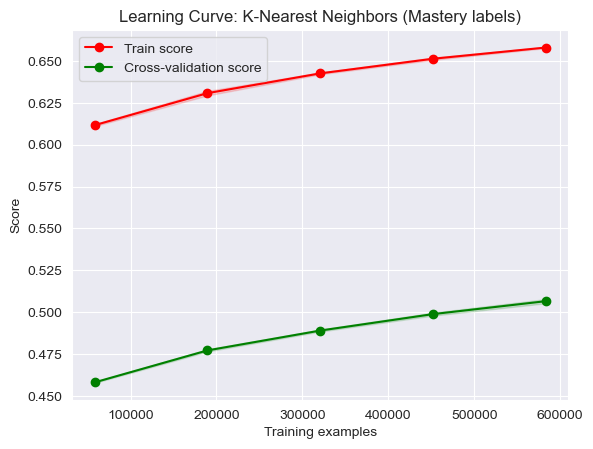


Learning curve: Gradient Boosting


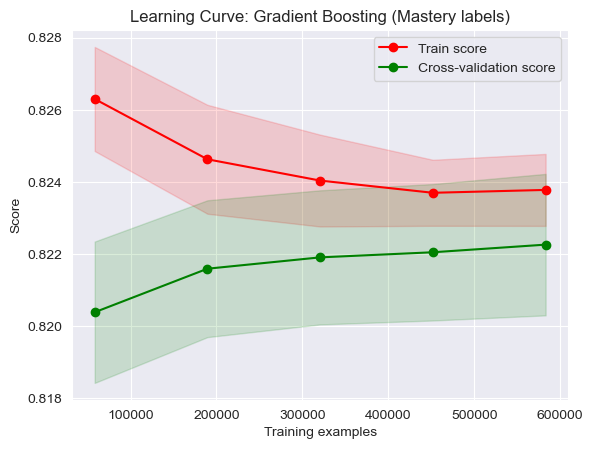


Learning curve: AdaBoost


/Users/anehra/anaconda3/envs/latest/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/anehra/anaconda3/envs/latest/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/anehra/anaconda3/envs/latest/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/anehra/anaconda3/envs/latest/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed i

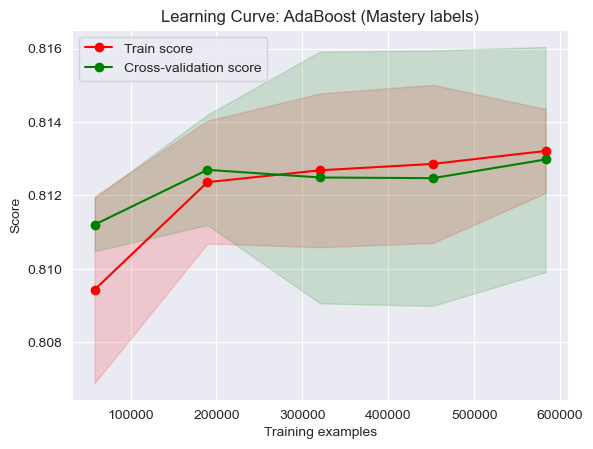


Learning curve: Gaussian Naive Bayes


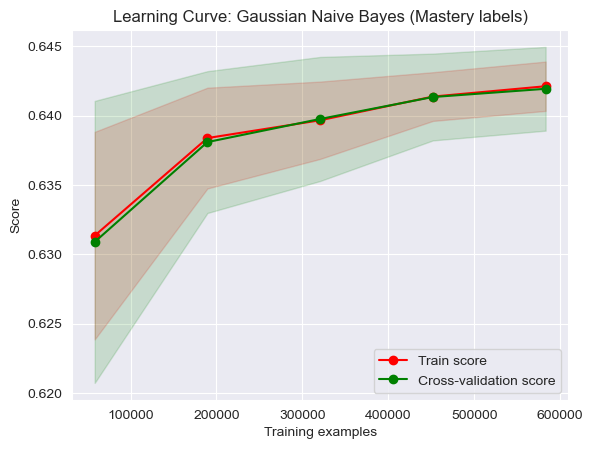

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

# Optional: For XGBoost, LightGBM, CatBoost (Uncomment if you have these packages)
# from xgboost import XGBClassifier
# from lightgbm import LGBMClassifier
# from catboost import CatBoostClassifier

models = [
    ("Logistic Regression", LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)),
    ("K-Nearest Neighbors", KNeighborsClassifier(n_neighbors=7)),
    ("Gradient Boosting", GradientBoostingClassifier(n_estimators=80, max_depth=5, random_state=RANDOM_STATE)),
    ("AdaBoost", AdaBoostClassifier(n_estimators=80, random_state=RANDOM_STATE)),
    ("Gaussian Naive Bayes", GaussianNB()),
    # ("Support Vector Machine", SVC(kernel='rbf', probability=True, random_state=RANDOM_STATE)),
    # ("XGBoost", XGBClassifier(n_estimators=80, max_depth=5, random_state=RANDOM_STATE)),
    # ("LightGBM", LGBMClassifier(n_estimators=80, max_depth=5, random_state=RANDOM_STATE)),
    # ("CatBoost", CatBoostClassifier(n_estimators=80, max_depth=5, verbose=0, random_state=RANDOM_STATE)),
]

# --- Quantile-based labels ---
print("\n=== PLOTTING LEARNING CURVES: Quantile labels ===")
d2 = agg_quantile.dropna(subset=['skill_level_quantile'])
X = d2[features]
y = d2['skill_level_quantile']

for name, model in models:
    print(f"\nLearning curve: {name}")
    plot_learning_curve(model, X, y, f"Learning Curve: {name} (Quantile labels)")

# --- Mastery-based labels ---
print("\n=== PLOTTING LEARNING CURVES: Mastery labels ===")
d2 = agg_mastery.dropna(subset=['skill_level_mastery'])
X = d2[features]
y = d2['skill_level_mastery']

for name, model in models:
    print(f"\nLearning curve: {name}")
    plot_learning_curve(model, X, y, f"Learning Curve: {name} (Mastery labels)")